1. Using TF Agents, design & implement a DQN  with 4 output neurons (one per possible action) that uses the Model class in the keras.models. [15 points]
2. Discuss the rationale of the activation functions & the loss function used in the network. [10 points]
3. Implement a strategy that adjusts the following hyperparameters: (i) the number of iterations, (ii) the number of episodes, (iii) the maximum number of steps, and (iv) the discount factor
 at each step. [50 points]
4. Train the agent on the LunarLander-v2 environment for a sufficient number of episodes to achieve a satisfactory level of performance. [10 points]
5. Analyze the agent's learning progress by plotting relevant performance metrics (e.g., cumulative rewards, episode length) over time. [10 points]
6.Discuss the challenges faced during training and potential strategies for further improving the agent's performance. [5 points]



In [2]:
!sudo apt-get update

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [634 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,046 kB]
Get:13 http://se

In [3]:
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libice-dev libopengl-dev libsm-dev libxfont2 libxkbfile1
  libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev
  libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev libxfont2
  libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 28 not upgraded.
Ne

In [4]:
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
pip install tf-agents


In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.trajectories.trajectory import to_transition

In [7]:
display = pyvirtualdisplay.Display(visible = 0,size = (1400,900)).start()

In [8]:
env = suite_gym.load("LunarLander-v2")


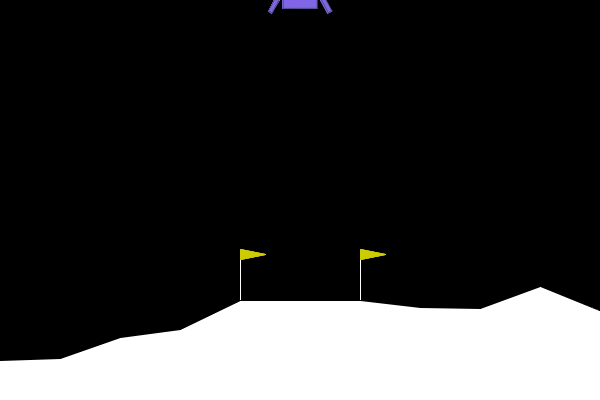

In [9]:
env.reset()
PIL.Image.fromarray(env.render())

In [10]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

In [11]:
tf_env=TFPyEnvironment(env)

In [12]:
tf_env.reset()

TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.0066802 ,  1.3992567 ,  0.67661554, -0.5183939 , -0.00773389,
        -0.1532636 ,  0.        ,  0.        ]], dtype=float32)>})

In [13]:
from tf_agents.networks.q_network import QNetwork

In [14]:
fc_layers_params = [512, 256]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layers_params
)

In [15]:
train_step_counter = tf.Variable(0)
update_period = 4
optimizer1 = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.07, decay_steps=25000, end_learning_rate=0.001)

In [16]:
agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer1,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.95,
    train_step_counter=train_step_counter,
    epsilon_greedy = lambda: epsilon_fn(train_step_counter)
)

In [17]:
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

In [18]:
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())


In [19]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec= agent.collect_data_spec, batch_size=tf_env.batch_size, max_length=2000)

In [20]:
replay_buffer_observer = replay_buffer.add_batch

In [21]:
from tf_agents.metrics import tf_metrics
train_metrics  = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [22]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [23]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
collect_driver  = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers = [replay_buffer_observer] + train_metrics,
    num_steps = update_period
)


In [24]:
from tf_agents.trajectories.trajectory import to_transition
dataset = replay_buffer.as_dataset(
    sample_batch_size= 64,
    num_steps=2,
    num_parallel_calls = 3
).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [25]:
def trainAgent(n):
  time_steps = None
  policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
  i = iter(dataset)
  for j in range(n):
    time_steps, policy_state = collect_driver.run(time_steps, policy_state)
    trajectories, buffer_info = next(i)
    train_loss = agent.train(trajectories)

    if j%100 == 0:
      log_metrics(train_metrics)


In [26]:
import matplotlib as mpl
mpl.rc('animation', html='jshtml')

In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,

def plot_animation(frames, repeat = False, interval = 35):
  fig = plt.figure()
  patch= plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs = (frames, patch),
      frames = len(frames), repeat = repeat, interval = interval)
  return anim


In [28]:
frames =[]
def save_frames(trajectory):
  global frames
  frames.append(tf_env.envs[0].render(mode = "rgb_array"))

In [29]:
class showProgress:
  def __init__(self, total):
    self.counter = 0
    self.total  = total
  def __call__(self, trajectory):
    if not trajectory.is_boundary():
      self.counter += 1
    if self.counter % 100 == 0:
      print("\r{}/{}".format(self.counter, self.total), end ="")

In [30]:
watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers = [save_frames, showProgress(1000)]
)

In [37]:
trainAgent(1000)

INFO:absl: 
		 NumberOfEpisodes = 44
		 EnvironmentSteps = 19443
		 AverageReturn = -136.06686401367188
		 AverageEpisodeLength = 869.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 44
		 EnvironmentSteps = 19843
		 AverageReturn = -136.06686401367188
		 AverageEpisodeLength = 869.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 44
		 EnvironmentSteps = 20243
		 AverageReturn = -136.06686401367188
		 AverageEpisodeLength = 869.7999877929688
INFO:absl: 
		 NumberOfEpisodes = 45
		 EnvironmentSteps = 20643
		 AverageReturn = -139.77999877929688
		 AverageEpisodeLength = 903.2999877929688
INFO:absl: 
		 NumberOfEpisodes = 45
		 EnvironmentSteps = 21043
		 AverageReturn = -139.77999877929688
		 AverageEpisodeLength = 903.2999877929688
INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 21443
		 AverageReturn = -143.0803985595703
		 AverageEpisodeLength = 903.2999877929688
INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 21843
		 AverageReturn = -143.0803985595703
		 Average

In [38]:
frames = []
watch_driver.run(time_step=tf_env.reset())


(TimeStep(
 {'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.08367945], dtype=float32)>,
  'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-0.00859718,  1.4015888 , -0.42844254, -0.22033285,  0.00782067,
          0.05568396,  0.        ,  0.        ]], dtype=float32)>}),
 ())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


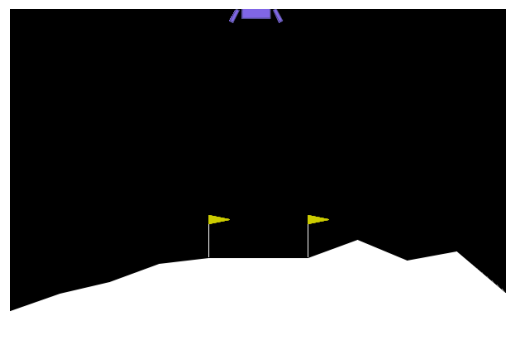

In [39]:
plot_animation(frames)